# Numerical Exercise 10

In [2]:
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np
from scipy.optimize import curve_fit
import statsmodels.api as sm
import math

prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']
selection = ["Exp law", "Roulette", "Tournament", "Stochastic"]
mapper = ["circle", "square", "provita"]
ex = ["ex09", "ex10"]
champ = ["best", "champion"]

# Assignment
### Exercise 10.1

Choose **ONLY ONE** of the two following possibilities:

1. Parallelize with MPI libraries your Genetic Algorithm code in order to solve the TSP by performing a *Genetic Search* with (up to) 11 **parallel GA searches of the optimal path**:
each node should perform an independent GA search, the so-called *Continent*, **but** every $N_{migr}$ generations the *Continents* should exchange their best individuals randomly.

2. Starting from your Genetic Algorithm code implement a **Parallel Tempering algorithm** (Simulated Annealing with many temperatures). Parallelize with MPI libraries your algorithm in order to solve the TSP where each computing node, up to 11, is characterized by a different temperature or a limited set of temperatures (if you need more than 11 temperatures). Use your genetic operators (except crossover) as trial moves for the Metropolis algorithm and **add a trial move that proposes an exchange of paths among adjacent temperatures (nodes)** (see lecture 8 for the acceptance formula). The candidate solution of the TSP will appear on the node with the lower temperature.
### Exercise 10.2

Apply your parallel code to the TSP problem for 110 italian "capoluoghi di provincia" longitude and latitude coordinates in the *cap_prov_ita.dat* file.

If your choice in Exercise 10.1 is option 1, do you improve with respect using the same number of computing cores but with **independent GA searches** ?

If your choice in Exercise 10.1 is option 2, by using a number of temperatures equal to the number of individuals in your **non-parallel Genetic Algorithm code**, do you "improve" with respect to it?

## Resolution
### Exercise 10.1
I choose to implement the first option. I parallelize the Genetic Algorithm code in order to solve the TSP by performing a Genetic Search with 11 parallel GA searches of the optimal path. Each node performs an independent GA search, the so-called Continent, but every $N_{migr}$ generations the Continents exchange their best individuals randomly.

No modifications have been made to the classes of the exercise 09, with the exception of a method for setting the seeds of the random numbers generator.

The parallelization has been implemented by using the MPI library. While a first version used coordinated `for` loops between the nodes, with the master one receiving the best individual from each node and sending back the best one with the `MPI_Send` and `MPI_Recv` functions; a second version has been implemented by using the `MPI_Bcast` and `MPI_Gather` functions, which requires minimun overhead and is more efficient. 

All the print functions and management of the output files is done by the master node, (rank 0).

The code leverages the `.memptr()` and `.colptr()` methods of the `arma::imat` class to send and receive the raw data.
After the $N_{migr}$ generations, the best individual of each node is sent to the master node in a `arma::imat` matrix, which is then shuffled and the column corresponding to the each node is sent back to the node.
The pseudo-code corresponding to the evolution and migration is:
```cpp
 for(int i{0}; i<500; i++){ // cycle over the generations
        if(i%Nmigr == 0 && i != 0){ // each Nmigr migrations migrate
            pop.GiveDistance();
            int champion = pop.getBestIndex(); // select the best champion index
            vector<double> v_bestlength(size);
            arma::ivec tribute = pop._apopulation.col(champion); // prepare the best
            MPI_Gather(tribute.memptr(), tribute.size(), MPI_INTEGER8, tributes.memptr(), tribute.size(), MPI_INTEGER8, 0, MPI_COMM_WORLD);
            if(rank == 0) tributes = shuffle(tributes, 1);
            MPI_Bcast(tributes.memptr(), tributes.size(), MPI_INTEGER8, 0, MPI_COMM_WORLD);
            pop._apopulation.col(champion) = tributes.col(rank);
            MPI_Gather(&r_gen, 1, MPI_INT, currentgens, 1, MPI_INT, 0, MPI_COMM_WORLD);
            if(rank == 0) fmt::print("Generations: {0}\r", currentgens[0]);
        }
        pubg.Reproduce(pop);
        pubg.Mutation(pop);
    }
```
With just two MPI functions, the code exchanges all the best individuals, with little memory overhead because we are sending all the individuals to all the nodes.
### Results
Again, as in previous exercises, we divide the plots for each type of mapping, and for each type of selection. For showing trends, we plot the values for the rank 0 node, which has the same RNG seed as the previous exercise, but has the contribution of the migrants.

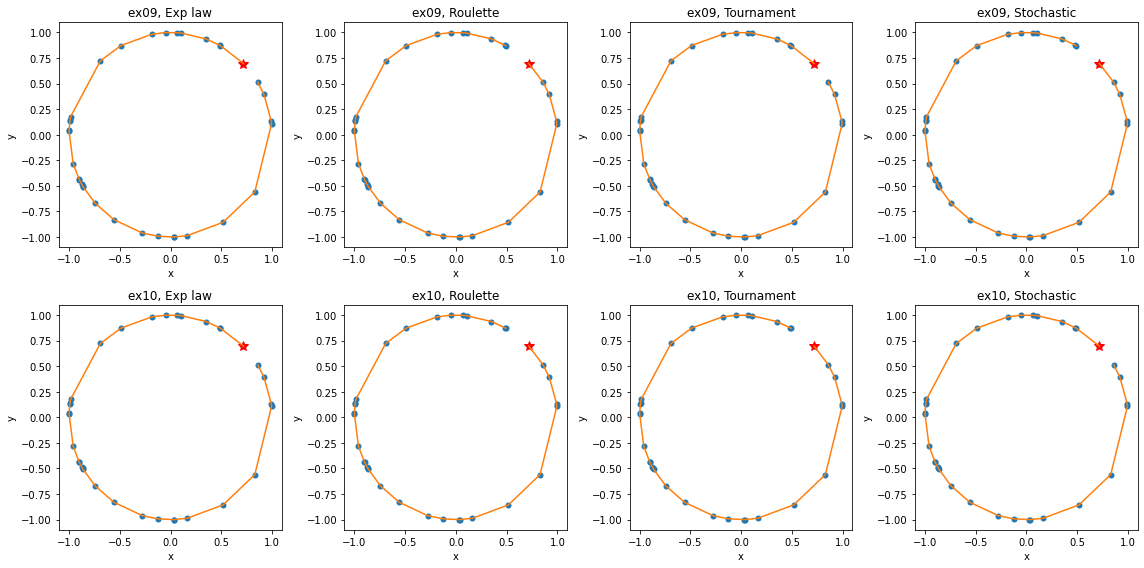

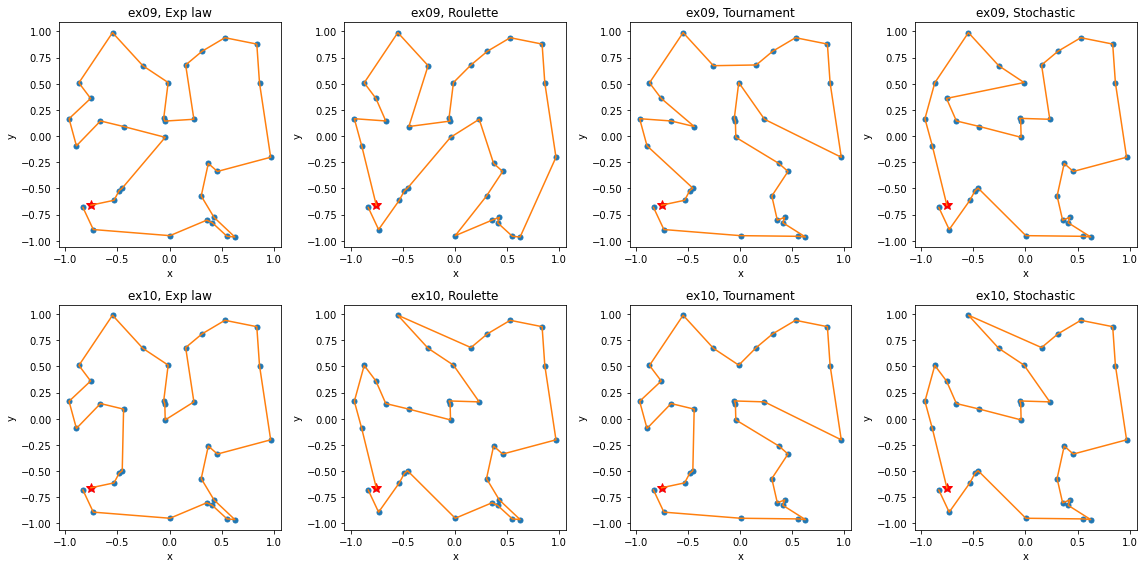

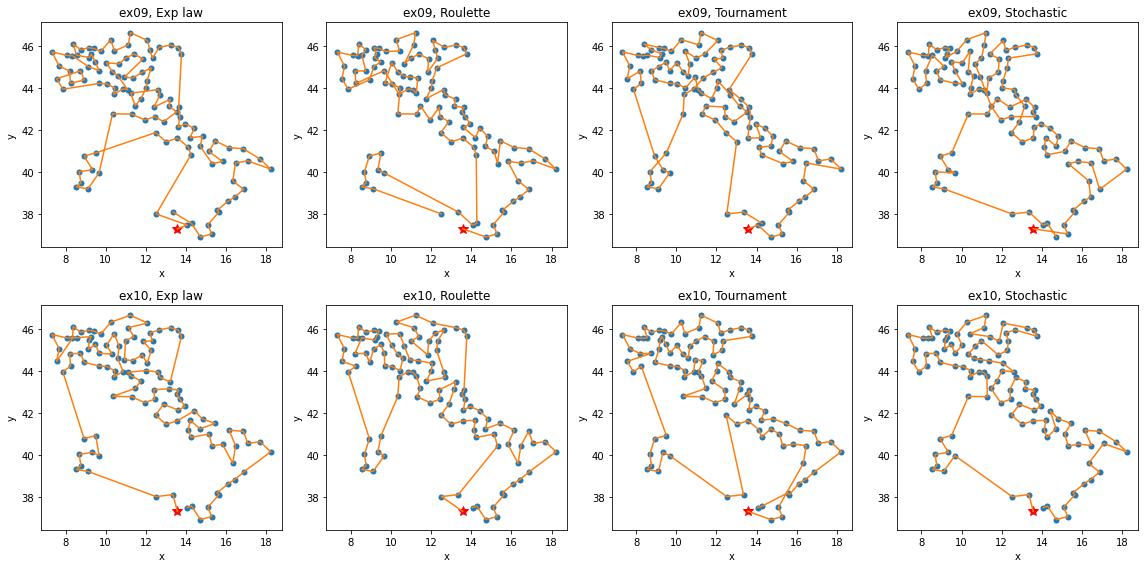

In [3]:
for atlas in mapper:
    x, y = np.loadtxt("../data/ex09_atlas_{atlante}.dat".format(atlante=atlas), unpack=True, usecols=(1, 2))
    fig = plt.figure(figsize=(16, 8))
    for j in range(0, 2):
        for i in range(0, 4):
            index = j*4+i
            plt.subplot(2,4, index+1)
            plt.plot(x, y, marker='o', markersize=5, linestyle='None')
            plt.plot(x[0], y[0], marker='*', markersize=10, color='red')
            plt.xlabel('x')
            plt.ylabel('y')
            plt.title('Plot of x and y')
            # print("../data/{exe}_{best}_{atlante}_{sel}.dat".format(exe=ex[j], best=champ[j], atlante=atlas, sel=i))
            x1, y1 = np.loadtxt("../data/{exe}_{best}_{atlante}_{sel}.dat".format(exe=ex[j], best=champ[j], atlante=atlas, sel=i), unpack=True, usecols=(1, 2))
            plt.title("{exe}, {sel}".format(exe=ex[j], sel=selection[i]))
            plt.plot(x1, y1)
            plt.tight_layout()
    plt.show()

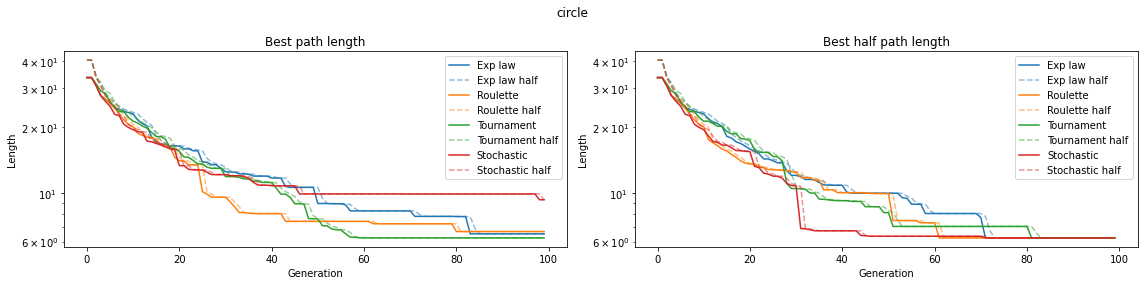

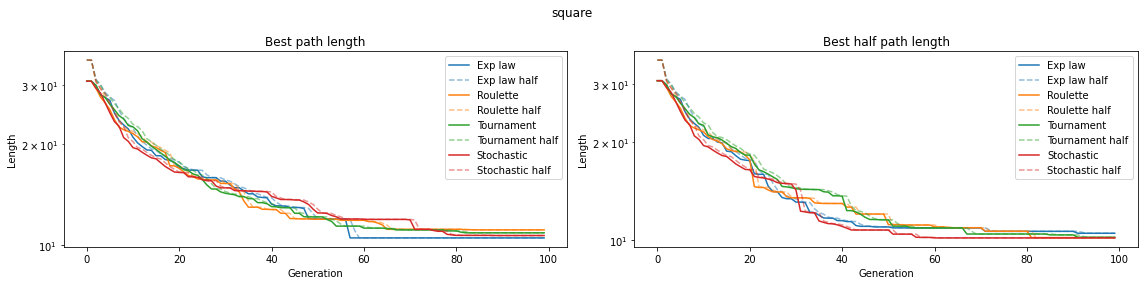

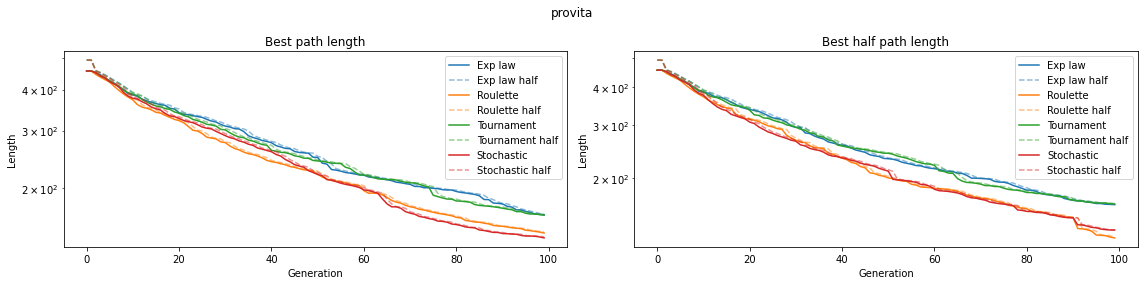

In [4]:
# plot best path length and best half path length
exs = ["ex09", "ex10_r0"]
first = 100
for atlas in mapper:
    fig, ax = plt.subplots(1, 2, figsize=(16, 4))
    for j in range(0, 2):
        for i in range(0, 4):
            n_gen, best, halfbest = np.loadtxt("../data/{exe}_values_{atlante}_{sel}.dat".format(exe=exs[j], atlante=atlas, sel=i), unpack=True, usecols=(0, 1, 2))
            ax[j].semilogy(n_gen[:first], best[:first], label=selection[i], color=colors[i])
            ax[j].semilogy(n_gen[:first], halfbest[:first], label=selection[i]+" half", color=colors[i], linestyle='--', alpha=0.5)
            ax[j].set_xlabel('Generation')
            ax[j].set_ylabel('Length')
            ax[j].legend()
    ax[0].set_title('Best path length')
    ax[1].set_title('Best half path length')
    plt.tight_layout()
    plt.suptitle(atlas)
    plt.tight_layout()
    plt.show()
     

../data/ex09_values_circle_0.dat
../data/ex09_values_circle_1.dat
../data/ex09_values_circle_2.dat
../data/ex09_values_circle_3.dat
../data/ex10_r0_values_circle_0.dat
../data/ex10_r0_values_circle_1.dat
../data/ex10_r0_values_circle_2.dat
../data/ex10_r0_values_circle_3.dat


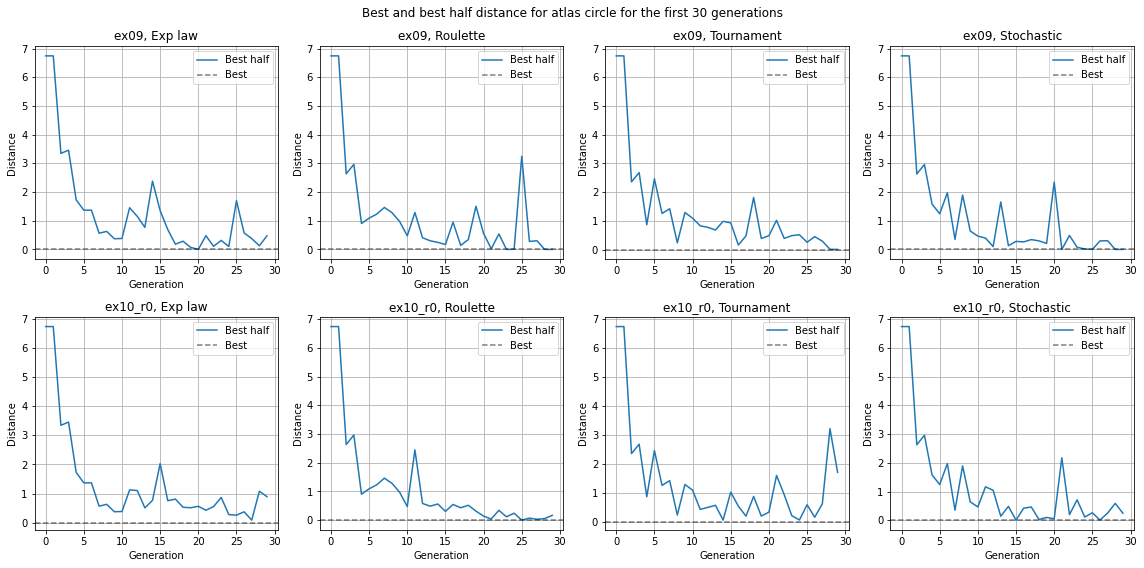

../data/ex09_values_square_0.dat
../data/ex09_values_square_1.dat
../data/ex09_values_square_2.dat
../data/ex09_values_square_3.dat
../data/ex10_r0_values_square_0.dat
../data/ex10_r0_values_square_1.dat
../data/ex10_r0_values_square_2.dat
../data/ex10_r0_values_square_3.dat


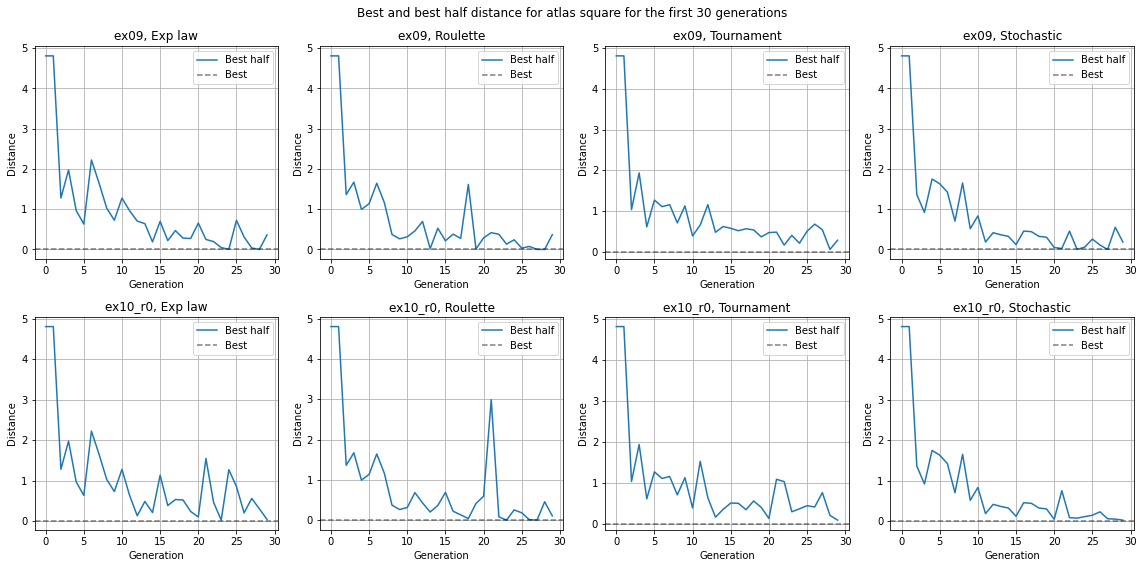

../data/ex09_values_provita_0.dat
../data/ex09_values_provita_1.dat
../data/ex09_values_provita_2.dat
../data/ex09_values_provita_3.dat
../data/ex10_r0_values_provita_0.dat
../data/ex10_r0_values_provita_1.dat
../data/ex10_r0_values_provita_2.dat
../data/ex10_r0_values_provita_3.dat


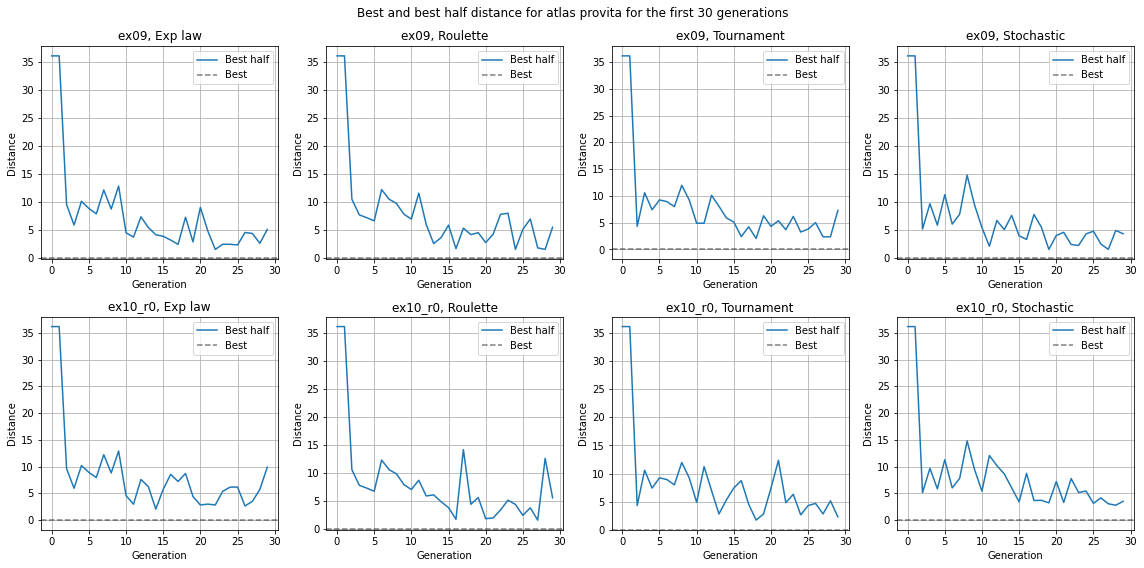

In [5]:
first = 30
exs = ["ex09", "ex10_r0"]

for atlas in mapper:
    fig, ax = plt.subplots(2, 4, figsize=(16, 8))
    for j in range(0, 2):
        for i in range(0, 4):
            print("../data/{exe}_values_{atlante}_{i}.dat".format(exe=exs[j], atlante=atlas, i=i))
            n_gen, best, best_half= np.loadtxt("../data/{exe}_values_{atlante}_{i}.dat".format(exe=exs[j], atlante=atlas, i=i), unpack=True, usecols=(0, 1, 2))
            # ax[i].plot(n_gen[:first], best[:first], label="Best")
            ax[j, i].plot(n_gen[:first], abs(best_half[:first]-best[:first]), label="Best half")
            # ax[j, i].errorbar(n_gen[:first], abs(mean[:first]-best[:first]), yerr=std[:first], label="Mean", alpha=0.5)
            ax[j, i].axhline(0, color='black', linestyle='--', alpha=0.5, label="Best")
            ax[j, i].set_xlabel("Generation")
            ax[j, i].set_ylabel("Distance")
            ax[j, i].set_title("{exe}, {sel}".format(exe=exs[j], sel=selection[i]))
            # ax[j, i].set_xscale('log')
            ax[j, i].legend()
            ax[j, i].grid()
    fig.suptitle("Best and best half distance for atlas {atlante} for the first {first} generations".format(atlante=atlas, first=first))
    plt.tight_layout()
    plt.show()

../data/ex09_values_circle_0.dat
../data/ex09_values_circle_1.dat
../data/ex09_values_circle_2.dat
../data/ex09_values_circle_3.dat
../data/ex10_r0_values_circle_0.dat
../data/ex10_r0_values_circle_1.dat
../data/ex10_r0_values_circle_2.dat
../data/ex10_r0_values_circle_3.dat


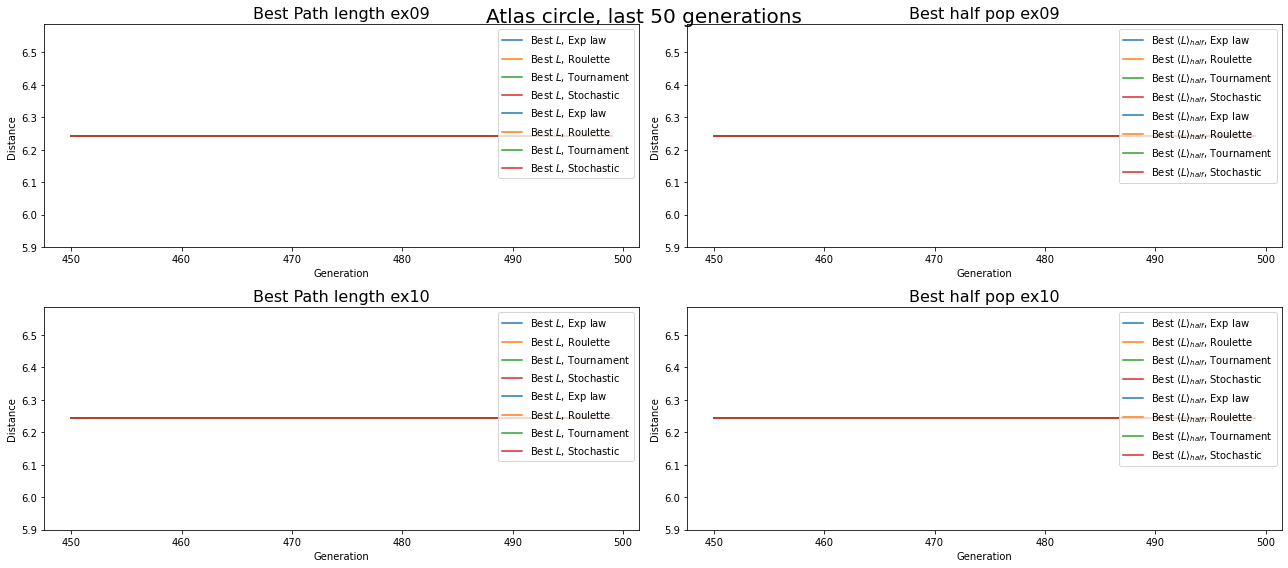

../data/ex09_values_square_0.dat
../data/ex09_values_square_1.dat
../data/ex09_values_square_2.dat
../data/ex09_values_square_3.dat
../data/ex10_r0_values_square_0.dat
../data/ex10_r0_values_square_1.dat
../data/ex10_r0_values_square_2.dat
../data/ex10_r0_values_square_3.dat


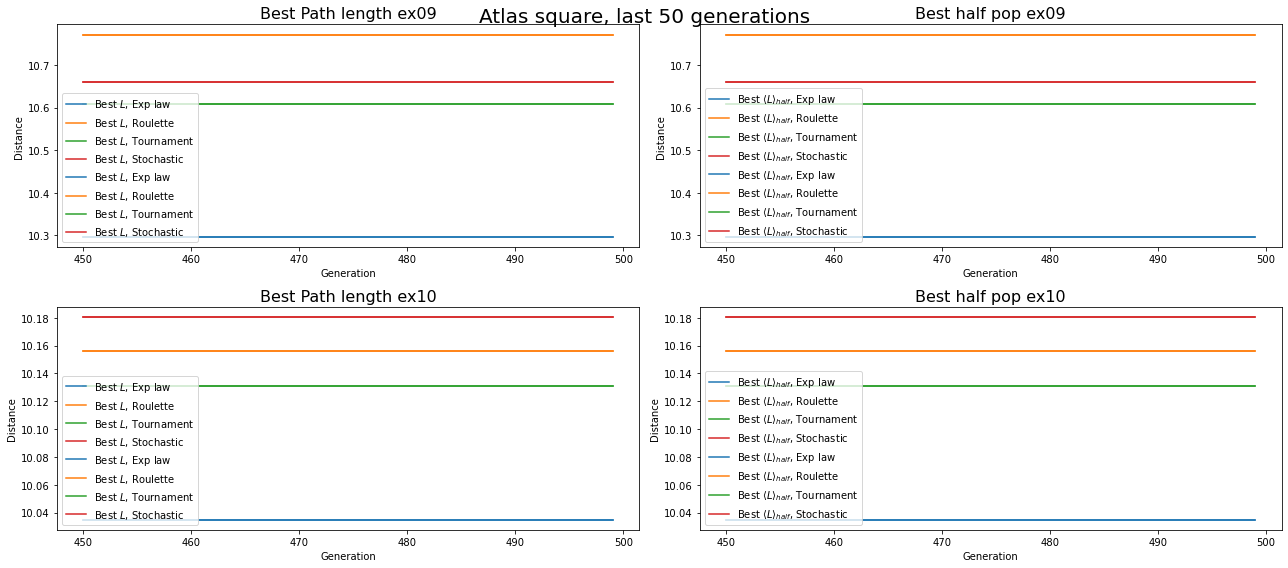

../data/ex09_values_provita_0.dat
../data/ex09_values_provita_1.dat
../data/ex09_values_provita_2.dat
../data/ex09_values_provita_3.dat
../data/ex10_r0_values_provita_0.dat
../data/ex10_r0_values_provita_1.dat
../data/ex10_r0_values_provita_2.dat
../data/ex10_r0_values_provita_3.dat


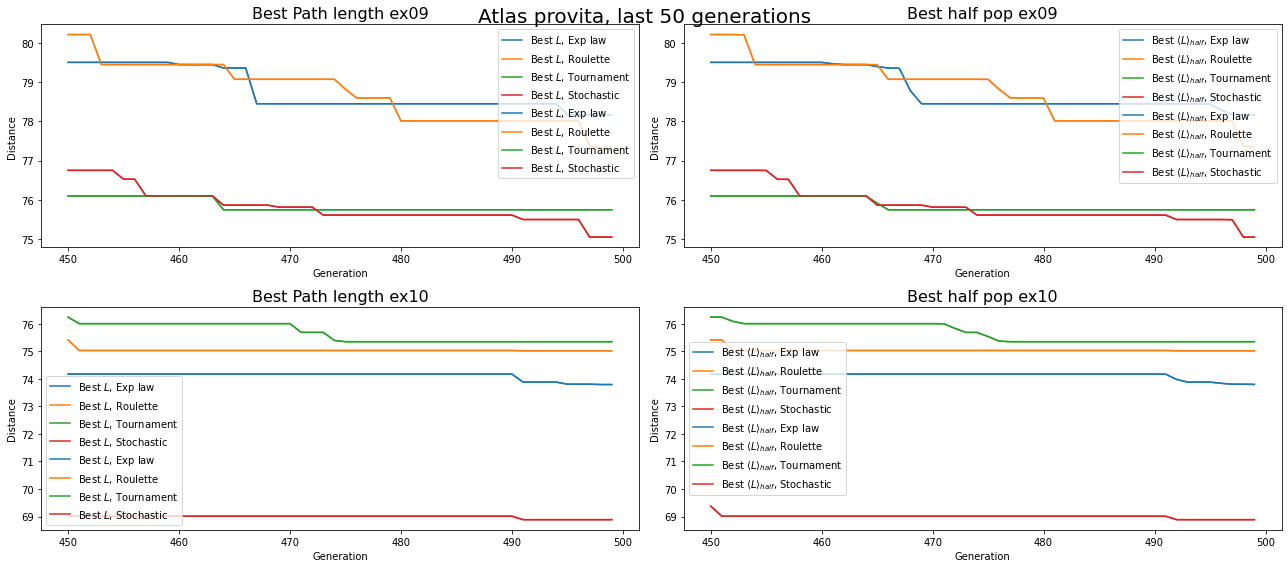

In [6]:
for atlas in mapper:
    fig = plt.figure(figsize=(18, 8))
    for l in range(0, 2):
        n_gen = []
        best_len = []
        best_half_len = []
        for i in range(4):
            if l == 1:
                filename = "../data/{exe}_r0_values_{atlante}_{i}.dat".format(exe=ex[l], atlante=atlas, i=i)
            else:
                filename = "../data/{exe}_values_{atlante}_{i}.dat".format(exe=ex[l], atlante=atlas, i=i)
            print(filename)
            n_gen.append(np.loadtxt(filename, unpack=True, usecols=(0)))
            best_len.append(np.loadtxt(filename, unpack=True, usecols=(1)))
            best_half_len.append(np.loadtxt(filename, unpack=True, usecols=(2)))
        squaregen = 50
        # np.sqrt(best_len)
        # np.sqrt(best_half_len)
        for i in range(2):
            index = l*2
            plt.subplot(2, 2, index+1)
            for j in range(4):
                plt.plot(n_gen[j][-squaregen:], best_len[j][-squaregen:], label=r"Best $L$, {sel}".format(sel=selection[j]), color=colors[j])
            plt.title("Best Path length {exe}".format(exe=ex[l]), fontsize=16)
            plt.ylabel('Distance')
            plt.xlabel('Generation')
            plt.grid()
            plt.legend()
            plt.subplot(2, 2, index+2)
            for j in range(4):
                plt.plot(n_gen[j][-squaregen:], best_half_len[j][-squaregen:], label=r"Best $\langle L \rangle_{half}$, {sel}".format(sel=selection[j], half="{half}"), color=colors[j])
            plt.title("Best half pop {exe}".format(exe=ex[l]), fontsize=16)
            plt.ylabel('Distance')
            plt.xlabel('Generation')
            plt.grid()
            plt.legend()
    plt.tight_layout()
    plt.suptitle("Atlas {atlante}, last {gen} generations".format(atlante=atlas, gen=squaregen), fontsize=20)
    plt.show()

Best distance for provita gen, Exp law selector
r0, len=[73.79281], half_len=[73.79631]
r1, len=[73.5635], half_len=[73.5635]
r2, len=[73.12528], half_len=[73.12528]
r3, len=[73.50729], half_len=[73.50729]
r4, len=[73.12528], half_len=[73.12528]
r5, len=[73.12528], half_len=[73.12528]
r6, len=[73.50729], half_len=[73.50729]
r7, len=[72.98501], half_len=[73.55771]
r8, len=[73.12528], half_len=[73.12528]
r9, len=[73.5635], half_len=[73.5635]
Best distance for provita gen, Roulette selector
r0, len=[75.01771], half_len=[75.01771]
r1, len=[75.02807], half_len=[75.02807]
r2, len=[74.2792], half_len=[74.2792]
r3, len=[75.01771], half_len=[75.01771]
r4, len=[74.69538], half_len=[74.69538]
r5, len=[75.01771], half_len=[75.01771]
r6, len=[75.01771], half_len=[75.01771]
r7, len=[75.01771], half_len=[75.01771]
r8, len=[75.01771], half_len=[75.01771]
r9, len=[75.01771], half_len=[75.01771]
Best distance for provita gen, Tournament selector
r0, len=[75.34779], half_len=[75.34779]
r1, len=[75.66491]

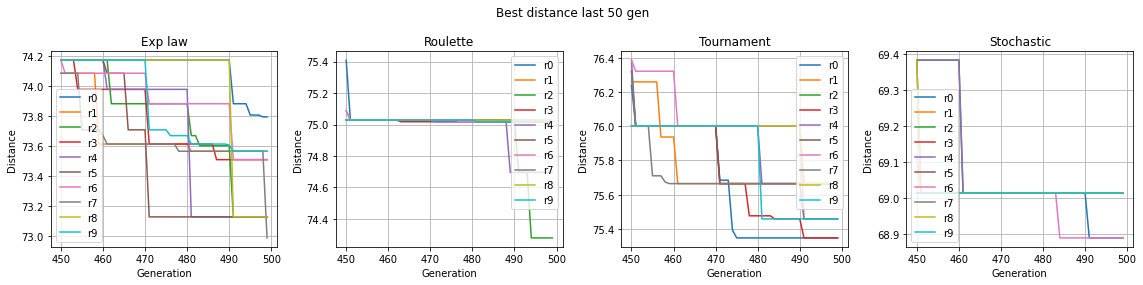

In [12]:
last = 50

fig, ax = plt.subplots(1, 4, figsize=(16, 4))
for i in range(0, 4):
    # print("../data/{exe}_values_{atlante}_{i}.dat".format(exe=exs[j], atlante=atlas, i=i))
    print("Best distance for provita gen, {sel} selector".format(sel=selection[i]))
    for k in range (0, 10):
        n_gen, best, best_half= np.loadtxt("../data/ex10_r{rank}_values_provita_{i}.dat".format(rank=k, atlante=atlas, i=i), unpack=True, usecols=(0, 1, 2))
        ax[i].plot(n_gen[-last:], best[-last:], label="r{rank}".format(rank=k))
        print("r{rank}, len={len}, half_len={half_len}".format(rank=k, len=best[-1:], half_len=best_half[-1:]))
    ax[i].set_xlabel("Generation")
    ax[i].set_ylabel("Distance")
    ax[i].set_title("{sel}".format(sel=selection[i]))
    ax[i].legend()
    ax[i].grid()
fig.suptitle("Best distance last {last} gen".format(atlante=atlas, last=last))
plt.tight_layout()
plt.show()

### Some observations
Again, the best algorithm for large number of points to travel by is the stochastic universal accceptance. We can see from the last 50 generations that the linear rank-based (exp law) and the tournament selection keeps the system varied in the difference of lenght. 
If we try to run the same algorithm with the same numbers of cores, but without the migration system, the program yields worst results. In fact, for the provinces of Italy, by permetting individuals to migrate between the nodes, the programs finds the best distance at 69, while without interaction, the best seed or the best node yields 73.

Best distance for circle gen, Exp law selector
r0, len=[6.24306], half_len=[6.24306]
r1, len=[6.24306], half_len=[6.24306]
r2, len=[6.24306], half_len=[6.24306]
r3, len=[6.24306], half_len=[6.24306]
r4, len=[6.24306], half_len=[6.24306]
r5, len=[6.24306], half_len=[6.24306]
r6, len=[6.24306], half_len=[6.24306]
r7, len=[6.24306], half_len=[6.24306]
r8, len=[6.24306], half_len=[6.24306]
r9, len=[6.24306], half_len=[6.24306]
Best distance for circle gen, Roulette selector
r0, len=[6.24306], half_len=[6.24306]
r1, len=[6.24306], half_len=[6.24306]
r2, len=[6.24306], half_len=[6.24306]
r3, len=[6.24306], half_len=[6.24306]
r4, len=[6.24306], half_len=[6.24306]
r5, len=[6.24306], half_len=[6.24306]
r6, len=[6.24306], half_len=[6.24306]
r7, len=[6.24306], half_len=[6.24306]
r8, len=[6.24306], half_len=[6.24306]
r9, len=[6.24306], half_len=[6.24306]
Best distance for circle gen, Tournament selector
r0, len=[6.24306], half_len=[6.24306]
r1, len=[6.24306], half_len=[6.24306]
r2, len=[6.24306], 

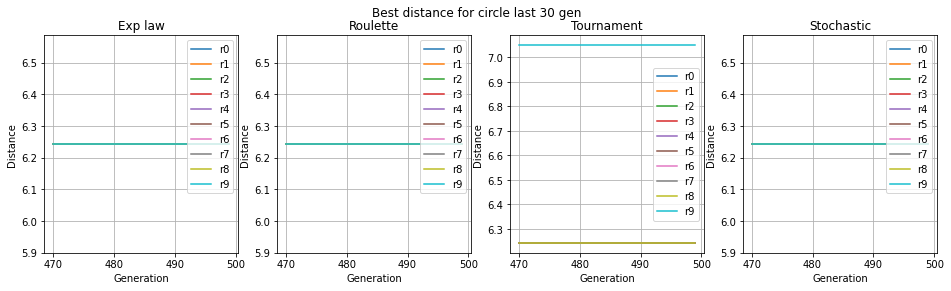

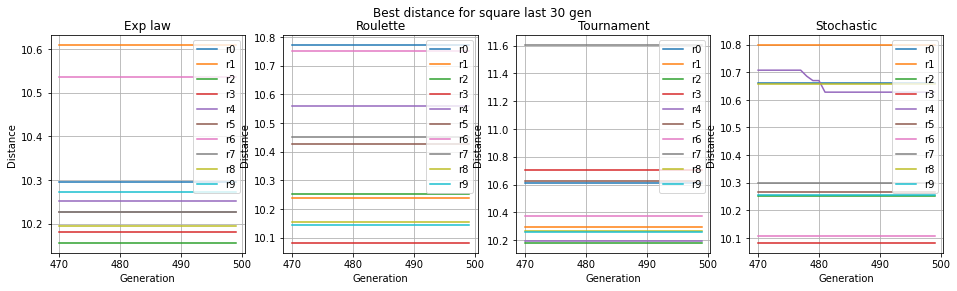

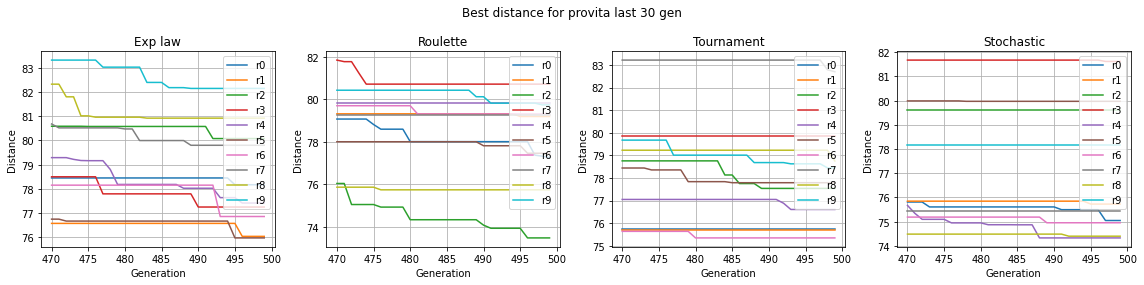

In [8]:
last = 30
exs = ["ex09", "ex10_r0"]

for atlas in mapper:
    fig, ax = plt.subplots(1, 4, figsize=(16, 4))
    for i in range(0, 4):
        # print("../data/{exe}_values_{atlante}_{i}.dat".format(exe=exs[j], atlante=atlas, i=i))
        print("Best distance for {atlante} gen, {sel} selector".format(atlante=atlas, sel=selection[i]))
        for k in range (0, 10):
            n_gen, best, best_half= np.loadtxt("../data/ex10_2_r{rank}_values_{atlante}_{i}.dat".format(rank=k, atlante=atlas, i=i), unpack=True, usecols=(0, 1, 2))
            ax[i].plot(n_gen[-last:], best[-last:], label="r{rank}".format(rank=k))
            print("r{rank}, len={len}, half_len={half_len}".format(rank=k, len=best[-1:], half_len=best_half[-1:]))
        ax[i].set_xlabel("Generation")
        ax[i].set_ylabel("Distance")
        ax[i].set_title("{sel}".format(sel=selection[i]))
        ax[i].legend()
        ax[i].grid()
    fig.suptitle("Best distance for {atlante} last {last} gen".format(atlante=atlas, last=last))
plt.tight_layout()
plt.show()